In [9]:
import zipfile
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [1]:
#install SoccerNet library
!pip install SoccerNet --upgrade

import SoccerNet
from SoccerNet.Downloader import SoccerNetDownloader

#create downloader
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory="/dataset/SoccerNet")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 25.2 MB/s eta 0:00:00


In [2]:
#set dataset directory
local_directory = "/content/SoccerNet"  # Colab의 경우 기본 경로

#create SoccerNetDownloader instance
my_downloader = SoccerNetDownloader(LocalDirectory=local_directory)

#download 10 games as test
download_index = 0

for download_index in range(0, 10):
  mySoccerNetDownloader.downloadGameIndex(download_index, files=["Labels-v3.json", "Frames-v3.zip"])

In [43]:
#download 10 games as test
download_index = 10

for download_index in range(10, 20):
  mySoccerNetDownloader.downloadGameIndex(download_index, files=["Labels-v3.json", "Frames-v3.zip"])

In [3]:
import json

folder1_path = "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Labels-v3.json"
folder2_path = "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal/Labels-v3.json"

#england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley
#open "Labels-v3.json" -1
with open(folder1_path, "r") as file1:
    data1 = json.load(file1)

#england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal
#open "Labels-v3.json" -2
with open(folder2_path, "r") as file2:
    data2 = json.load(file2)

# "actions" 섹션에서 각 이미지 파일의 label 추출
actions1 = data1["actions"]
actions2 = data2["actions"]

labels1 = {}
labels2 = {}

for image, metadata in actions1.items():
    labels1[image] = metadata["imageMetadata"]["label"]

for image, metadata in actions2.items():
    labels2[image] = metadata["imageMetadata"]["label"]

#print and check the pairing of images and labels
print("england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley")
for image, label in labels1.items():
    print(f"Image: {image}, Label: {label}")

print("\n\nengland_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal")
for image, label in labels2.items():
    print(f"Image: {image}, Label: {label}")

england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley
Image: 0.png, Label: Ball out of play
Image: 1.png, Label: Goal
Image: 2.png, Label: Clearance
Image: 3.png, Label: Shots off target
Image: 4.png, Label: Ball out of play
Image: 5.png, Label: Foul
Image: 6.png, Label: Corner
Image: 7.png, Label: Ball out of play
Image: 8.png, Label: Foul
Image: 9.png, Label: Foul
Image: 10.png, Label: Shots on target
Image: 11.png, Label: Ball out of play
Image: 12.png, Label: Ball out of play
Image: 13.png, Label: Shots on target
Image: 14.png, Label: Ball out of play
Image: 15.png, Label: Clearance
Image: 16.png, Label: Throw-in
Image: 17.png, Label: Shots off target
Image: 18.png, Label: Shots off target
Image: 19.png, Label: Ball out of play
Image: 20.png, Label: Goal
Image: 21.png, Label: Throw-in
Image: 22.png, Label: Shots off target


england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal
Image: 0.png, Label: Offside
Image: 1.png, Label: Foul
Image: 2.png, Label: Foul

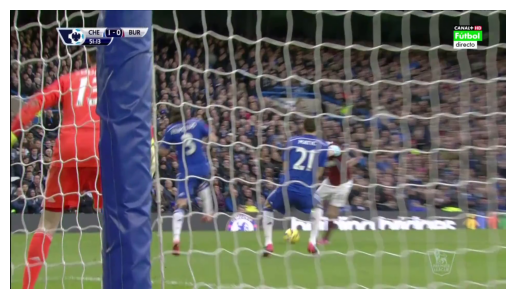

In [5]:
zip_path = "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Frames-v3.zip"

#open zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    image_names = [name for name in zip_ref.namelist() if name.endswith(".png")]

    with zip_ref.open(image_names[0]) as image_file:
        image = Image.open(image_file)
        #visualization sample image
        plt.imshow(image)
        plt.axis("off") #set axes invisible.
        plt.show()

Loaded 60 images and 60 labels.


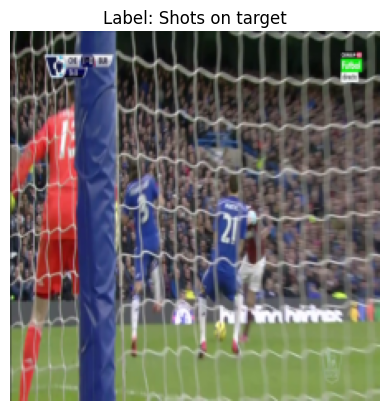

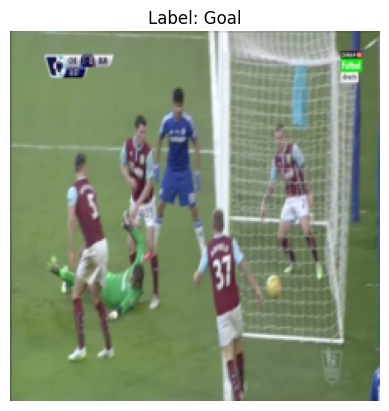

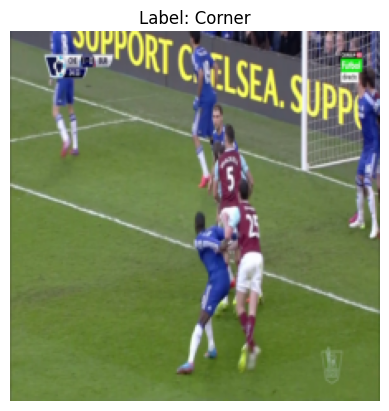

In [82]:
#matching png file from zip folder and label from json file
zip_path = "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Frames-v3.zip"
json_path = "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Labels-v3.json"

#image transformation pipeline (convert to PyTorch tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #resize
    transforms.ToTensor(),          #convert to tensor
])

image_tensors = []
labels = []

with open(json_path, "r") as f:
    label_data = json.load(f)

#open zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    image_names = [name for name in zip_ref.namelist() if name.endswith(".png")]

    for image_name in image_names:
        #open png file
        with zip_ref.open(image_name) as image_file:
            image = Image.open(image_file).convert("RGB")  #convert to RGB
            #convert to image tensor
            image_tensor = transform(image)
            image_tensors.append(image_tensor)

        #find labels corresponding to image file and modify image name included '_' (underbar) to use as index
        if '_' in image_name:
          base_name = image_name.split("_")[0] + ".png"
        else:
          base_name = image_name
        label = label_data["actions"].get(base_name, {}).get("imageMetadata", {}).get("label", "Unknown")
        labels.append(label)

#check the number of images and labels
print(f"Loaded {len(image_tensors)} images and {len(labels)} labels.")

num_visualize = 3

for i in range(num_visualize):
    image = image_tensors[i].permute(1, 2, 0).numpy()
    label = labels[i]

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Label: {label}")
    plt.show()

In [44]:
data_paths = [
    "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley",
    "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal",
    "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United",
    "/dataset/SoccerNet/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-08-08 - 19-30 Chelsea 2 - 2 Swansea",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-08-29 - 17-00 Chelsea 1 - 2 Crystal Palace",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-08-29 - 17-00 Manchester City 2 - 0 Watford",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-09-12 - 14-45 Everton 3 - 1 Chelsea",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-09-12 - 17-00 Crystal Palace 0 - 1 Manchester City",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-09-19 - 19-30 Manchester City 1 - 2 West Ham",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-09-26 - 17-00 Liverpool 3 - 2 Aston Villa",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-10-17 - 17-00 Chelsea 2 - 0 Aston Villa",
     "/dataset/SoccerNet/england_epl/2015-2016/2015-10-31 - 15-45 Chelsea 1 - 3 Liverpool",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-11-07 - 18-00 Manchester United 2 - 0 West Brom",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-11-21 - 20-30 Manchester City 1 - 4 Liverpool",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-11-29 - 15-00 Tottenham 0 - 0 Chelsea",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-12-05 - 20-30 Chelsea 0 - 1 Bournemouth",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-12-19 - 18-00 Chelsea 3 - 1 Sunderland",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-12-26 - 18-00 Manchester City 4 - 1 Sunderland",
    "/dataset/SoccerNet/england_epl/2015-2016/2016-01-03 - 16-30 Crystal Palace 0 - 3 Chelsea",
]

In [45]:
#split dataset as train, test, valid 3 categories
train_paths, temp_paths = train_test_split(data_paths, test_size=0.3, random_state=42)
test_paths, val_paths = train_test_split(temp_paths, test_size=0.33, random_state=42)

print("Train Paths:", train_paths)
print("Test Paths:", test_paths)
print("Validation Paths:", val_paths)

Train Paths: ['/dataset/SoccerNet/england_epl/2015-2016/2015-10-17 - 17-00 Chelsea 2 - 0 Aston Villa', '/dataset/SoccerNet/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool', '/dataset/SoccerNet/england_epl/2015-2016/2015-12-26 - 18-00 Manchester City 4 - 1 Sunderland', '/dataset/SoccerNet/england_epl/2015-2016/2015-12-05 - 20-30 Chelsea 0 - 1 Bournemouth', '/dataset/SoccerNet/england_epl/2015-2016/2015-11-07 - 18-00 Manchester United 2 - 0 West Brom', '/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United', '/dataset/SoccerNet/england_epl/2015-2016/2015-09-19 - 19-30 Manchester City 1 - 2 West Ham', '/dataset/SoccerNet/england_epl/2015-2016/2016-01-03 - 16-30 Crystal Palace 0 - 3 Chelsea', '/dataset/SoccerNet/england_epl/2015-2016/2015-08-08 - 19-30 Chelsea 2 - 2 Swansea', '/dataset/SoccerNet/england_epl/2015-2016/2015-10-31 - 15-45 Chelsea 1 - 3 Liverpool', '/dataset/SoccerNet/england_epl/2015-2016/2015-09-12 - 14-45 Everton 3 

In [83]:
class SoccerNetDataset(Dataset):
    def __init__(self, data_paths, transform):
        self.data_paths = data_paths
        self.transform = transform
        self.image_tensors = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for path in self.data_paths:
            zip_path = os.path.join(path, "Frames-v3.zip")      #zip -> png image
            json_path = os.path.join(path, "Labels-v3.json")    #json -> action label

            print(f"Loading JSON from: {json_path}")
            print(f"Loading ZIP from: {zip_path}")

            #load label data
            with open(json_path, "r") as f:
                label_data = json.load(f)

            #open zip file
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                image_names = [name for name in zip_ref.namelist() if name.endswith(".png")]

                for image_name in image_names:
                    #open and process image
                    with zip_ref.open(image_name) as image_file:
                        image = Image.open(image_file).convert("RGB")
                        image_tensor = self.transform(image)
                        self.image_tensors.append(image_tensor)

                    #extract label
                    base_name = image_name.split("_")[0] + ".png" if "_" in image_name else image_name
                    label = label_data["actions"].get(base_name, {}).get("imageMetadata", {}).get("label", "Unknown")
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):
        return {
            "image": self.image_tensors[idx],
            "label": self.labels[idx],
        }

#create data set
train_dataset = SoccerNetDataset(train_paths, transform)
test_dataset = SoccerNetDataset(test_paths, transform)
val_dataset = SoccerNetDataset(val_paths, transform)

#create dataloader
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Loading JSON from: /dataset/SoccerNet/england_epl/2015-2016/2015-10-17 - 17-00 Chelsea 2 - 0 Aston Villa/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2015-2016/2015-10-17 - 17-00 Chelsea 2 - 0 Aston Villa/Frames-v3.zip
Loading JSON from: /dataset/SoccerNet/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool/Frames-v3.zip
Loading JSON from: /dataset/SoccerNet/england_epl/2015-2016/2015-12-26 - 18-00 Manchester City 4 - 1 Sunderland/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2015-2016/2015-12-26 - 18-00 Manchester City 4 - 1 Sunderland/Frames-v3.zip
Loading JSON from: /dataset/SoccerNet/england_epl/2015-2016/2015-12-05 - 20-30 Chelsea 0 - 1 Bournemouth/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2015-2016/2015-12-05 - 20-30 Chelsea 0 - 1 Bournemouth/Frames-v3.zip
Loading JSON from: /dataset/So

In [84]:
# CLIP 모델과 프로세서 초기화
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Optimizer 및 Scheduler
LEARNING_RATE = 1e-5
EPOCHS = 5
optimizer = torch.optim.AdamW(clip_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# Contrastive Loss 계산 함수
def contrastive_loss(logits_per_image, logits_per_text, batch_size):
    target = torch.arange(batch_size).to(DEVICE)
    image_loss = torch.nn.CrossEntropyLoss()(logits_per_image, target)
    text_loss = torch.nn.CrossEntropyLoss()(logits_per_text, target)
    return (image_loss + text_loss) / 2

# 학습 루프
clip_model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in train_loader:
        # 데이터 로드
        images = batch["image"].to(DEVICE)
        texts = batch["label"]

        # CLIP 입력 데이터 생성
        inputs = clip_processor(text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False).to(DEVICE)

        # 모델 출력
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        # Loss 계산
        loss = contrastive_loss(logits_per_image, logits_per_text, batch_size=images.size(0))
        total_loss += loss.item()

        # Backpropagation 및 Optimizer Step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning Rate Scheduler 업데이트
    scheduler.step()

    # 에포크당 평균 손실 출력
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}")

print("Training Complete!")

Epoch [1/5], Loss: 1.8248
Epoch [2/5], Loss: 1.5504
Epoch [3/5], Loss: 1.1996
Epoch [4/5], Loss: 1.0226
Epoch [5/5], Loss: 0.8740
Training Complete!


In [39]:
# 모델을 평가 모드로 설정
clip_model.eval()

# 테스트 데이터셋에 대해 예측 수행
correct = 0
total = 0

with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
    for batch in test_loader:
        images = batch["image"].to(DEVICE)
        texts = batch["label"]

        # CLIP 입력 데이터 생성
        inputs = clip_processor(text=texts, images=images, return_tensors="pt", padding=True).to(DEVICE)

        # 모델 출력
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        # 이미지와 텍스트의 유사도를 기반으로 예측
        predicted_labels = torch.argmax(logits_per_image, dim=1)  # 이미지에 대한 예측
        actual_labels = torch.arange(images.size(0)).to(DEVICE)  # 실제 라벨 (배치에서 순서대로)

        # 예측 정확도 계산
        correct += (predicted_labels == actual_labels).sum().item()
        total += images.size(0)

# 정확도 출력
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")


KeyboardInterrupt: 

In [40]:
# 예측할 수 있는 라벨 배열
labels = ["Goal", "Foul", "Shot on target", "Clearance", "Throw-in"]

# 테스트 데이터셋에서 이미지를 가져옵니다.
image = test_dataset[0]["image"].unsqueeze(0).to(DEVICE)

# 각 라벨에 대해 텍스트를 CLIP 모델에 전달하여 이미지와의 유사도를 계산합니다.
text_inputs = clip_processor(text=labels, images=image, return_tensors="pt", padding=True).to(DEVICE)

# 모델 출력값을 얻습니다.
outputs = clip_model(**text_inputs)
logits_per_image = outputs.logits_per_image  # 이미지와 텍스트의 유사도

# 가장 유사도가 높은 라벨을 예측합니다.
predicted_label = labels[logits_per_image.argmax()]

print(f"Predicted label: {predicted_label}")

Predicted label: Goal


In [41]:
# 학습 데이터셋에서 모든 고유한 라벨을 추출하여 labels 배열 생성
labels_list = list(set([data["label"] for data in train_dataset]))

# labels 배열을 출력하여 확인
print("Possible labels:", labels_list)

Possible labels: ['Offside', 'Foul', 'Shots on target', 'Direct free-kick', 'Goal', 'Clearance', 'Shots off target', 'Ball out of play', 'Indirect free-kick', 'Throw-in', 'Corner']


In [42]:
# 총 테스트 데이터셋에서 예측한 라벨이 실제 라벨과 일치하는지 확인
correct = 0
total = len(test_dataset)

clip_model.eval()  # 평가 모드로 전환

for i in range(total):
    # 이미지와 해당 텍스트 레이블을 가져옵니다.
    image = test_dataset[i]["image"].unsqueeze(0).to(DEVICE)
    true_label = test_dataset[i]["label"]  # 실제 라벨 (예: "Goal", "Foul" 등)

    # 각 라벨에 대해 유사도 계산
    text_inputs = clip_processor(text=labels, images=image, return_tensors="pt", padding=True).to(DEVICE)

    # 모델 출력값을 얻습니다.
    outputs = clip_model(**text_inputs)
    logits_per_image = outputs.logits_per_image  # 이미지와 텍스트 간의 유사도

    # 가장 유사도가 높은 라벨을 예측
    predicted_label = labels_list[logits_per_image.argmax()]

    # 예측이 실제 라벨과 일치하면 correct 증가
    if predicted_label == true_label:
        correct += 1

# 정확도 계산
accuracy = correct / total
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 2.34%


In [ ]:
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device)

# Convert image tensors to a batch of tensors
image_batch = torch.stack(image_tensors).to(device)

# Preprocess the image tensors for CLIP
text_inputs = torch.cat([clip.tokenize(label) for label in labels]).to(device)

# Generate features for images and text
with torch.no_grad():
    image_features = clip_model.encode_image(image_batch)
    text_features = clip_model.encode_text(text_inputs)

# Normalize features
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

# Calculate cosine similarity between images and texts
cosine_similarity = (image_features @ text_features.T)

# Print out the cosine similarities for the first few images
for i in range(min(10, len(cosine_similarity))):
    print(f"Image {i} similarity: {cosine_similarity[i]}")


100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 53.8MiB/s]


Image 0 similarity: tensor([0.2509, 0.2242, 0.2383, 0.2074, 0.2288, 0.2242, 0.2074, 0.2509, 0.2074,
        0.2257, 0.2242, 0.2074, 0.2373, 0.2509, 0.2373, 0.2287, 0.2074, 0.2242,
        0.2242, 0.2074, 0.2074, 0.2287, 0.2288, 0.2287, 0.2287, 0.2288, 0.2074,
        0.2074, 0.2257, 0.2373, 0.2074, 0.2074, 0.2373, 0.2074, 0.2074, 0.2287,
        0.2074, 0.2383, 0.2074, 0.2257, 0.2242, 0.2287, 0.2242, 0.2287, 0.2287,
        0.2257, 0.2509, 0.2242, 0.2257, 0.2257, 0.2074, 0.2288, 0.2074, 0.2257,
        0.2242, 0.2383, 0.2242, 0.2287, 0.2242, 0.2242])
Image 1 similarity: tensor([0.2750, 0.2260, 0.2497, 0.2258, 0.2515, 0.2260, 0.2258, 0.2750, 0.2258,
        0.2402, 0.2260, 0.2258, 0.2592, 0.2750, 0.2592, 0.2530, 0.2258, 0.2260,
        0.2260, 0.2258, 0.2258, 0.2530, 0.2515, 0.2530, 0.2530, 0.2515, 0.2258,
        0.2258, 0.2402, 0.2592, 0.2258, 0.2258, 0.2592, 0.2258, 0.2258, 0.2530,
        0.2258, 0.2497, 0.2258, 0.2402, 0.2260, 0.2530, 0.2260, 0.2530, 0.2530,
        0.2402, 0.2750,

In [ ]:
final_labels = list(set(labels))

print("Unique labels:")
for label in final_labels:
    print(label)

Unique labels:
Goal
Ball out of play
Shots on target
Throw-in
Corner
Clearance
Foul
Shots off target


In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-fgk83vzz
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-fgk83vzz
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=65826c80e0d59805315babd57da5d8307a5be398545642036dec79554254118b
  Stored in directory: /tmp/pip-ephem-wheel-cache-ss3st5pe/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
def predict_label(image_tensor):
    # Generate text inputs for each action
    text_inputs = torch.cat([clip.tokenize(action) for action in final_labels]).to(device)

    # Get image and text features from CLIP model
    with torch.no_grad():
        image_features = clip_model.encode_image(image_tensor)
        text_features = clip_model.encode_text(text_inputs)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Compute the cosine similarity between the image and each label
    cosine_similarity = (image_features @ text_features.T).squeeze(0)

    # Get the index of the highest similarity
    label_index = cosine_similarity.argmax().item()

    # Return the label with the highest similarity
    return final_labels[label_index]

In [ ]:
# Example usage
image_path = "/dataset/SoccerNet/england_epl/2015-2016/2015-09-12 - 17-00 Crystal Palace 0 - 1 Manchester City/Frames-v3.zip"  # Replace with actual image path

#image transformation pipeline (convert to PyTorch tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #resize
    transforms.ToTensor(),          #convert to tensor
])

image_tensors = []
labels = []

#open zip file
with zipfile.ZipFile(image_path, 'r') as zip_ref:

    image_names = [name for name in zip_ref.namelist() if name.endswith(".png")]

    for image_name in image_names:
        #open png file
        with zip_ref.open(image_name) as image_file:
            image = Image.open(image_file).convert("RGB")  #convert to RGB
            #convert to image tensor
            image_tensor = transform(image)
            image_tensors.append(image_tensor)

        #find labels corresponding to image file and modify image name included '_' (underbar) to use as index
        if '_' in image_name:
          base_name = image_name.split("_")[0] + ".png"
        else:
          base_name = image_name
        label = label_data["actions"].get(base_name, {}).get("imageMetadata", {}).get("label", "Unknown")
        labels.append(label)

# Predict the label
predicted_label = predict_label(image_tensor[0])
print(f"The predicted label for the image is: {predicted_label}")

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [224, 224]

In [ ]:
from PIL import Image
import json

# SoccerNet의 텍스트 설명과 이미지 샘플 가져오기
with open("./SoccerNet/train/1_2_3_labels.json", "r") as f:
    data = json.load(f)

texts = [event["label"] for event in data["annotations"]]
images = [Image.open("./path_to_images/" + event["image_path"]) for event in data["annotations"]]

# CLIP 입력으로 변환
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)
inputs = {key: val.to(device) for key, val in inputs.items()}


In [ ]:
from torch.nn import functional as F

# 이미지-텍스트 임베딩 계산
outputs = model(**inputs)
image_features = outputs.image_embeds
text_features = outputs.text_embeds

# 유사도 계산 (예: 코사인 유사도)
logits_per_image = F.cosine_similarity(image_features, text_features.unsqueeze(0))


In [ ]:
mySoccerNetDownloader.downloadGames(files=["Labels-v2.json"], split=["train","valid","test"])

In [ ]:
dir(mySoccerNetDownloader)

['LocalDirectory',
 'OwnCloudServer',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'client_id',
 'downloadDataTask',
 'downloadFile',
 'downloadGame',
 'downloadGameIndex',
 'downloadGames',
 'downloadRAWVideo',
 'downloadVideo',
 'downloadVideoHD',
 'password']

In [ ]:
help(mySoccerNetDownloader.downloadGame)

Help on method downloadGame in module SoccerNet.Downloader:

downloadGame(game, files=['1.mkv', '2.mkv', 'Labels.json'], spl='train', verbose=True) method of SoccerNet.Downloader.SoccerNetDownloader instance



In [ ]:
!git clone https://github.com/SilvioGiancola/SoccerNet-code.git

Cloning into 'SoccerNet-code'...
remote: Enumerating objects: 627, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 627 (delta 0), reused 0 (delta 0), pack-reused 624 (from 1)
Receiving objects: 100% (627/627), 136.79 MiB | 26.64 MiB/s, done.
Resolving deltas: 100% (224/224), done.


In [ ]:
index = 0

for index in range(0, 10):
  mySoccerNetDownloader.downloadGameIndex(index, files=["Labels-v3.json", "Frames-v3.zip"])

/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal/Frames-v3.zip already exists


In [ ]:
# 설치
!pip install openai-clip torchvision SoccerNet --upgrade

# 라이브러리 임포트
import clip
import torch
from torchvision import transforms
from PIL import Image
from SoccerNet.Downloader import SoccerNetDownloader
import os


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=4c1e8e03c44b22c22ba288fcbdfa5614871814ab2c2c74226e575ef61f433955
  Stored in directory: /root/.cache/pip/wheels/08/77/8e/8d2f862df6bf7fb4e2007062d2cbaeae49862ec7b56d041229
Successfully built openai-clip


In [ ]:
# CLIP 모델과 Tokenizer 로드
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 107MiB/s]


In [ ]:
import numpy as np
import random
# import h5py
import os
import random
import json

from operator import itemgetter
import heapq
import time
from tqdm import tqdm


class dataset():

    # Initialization, takes into
    def __init__(self, ):
        print("Init")
        # training
        self.num_classes = 4
        self.count_labels = np.array([0, 0, 0, 0])
        self.size_batch = 0
        self.nb_batch_training = 0
        self.nb_epoch_per_batch = 1



    def loadTrainingDataset(self, path_data, featureName, PCA=True, imbalance="", batch_size=60, window_size_sec=60):

        self.imbalance = imbalance
        self.size_batch = batch_size
        self.PCA = PCA
        self.featureName = featureName
        self.window_size_sec = window_size_sec

        FeaturePerSecond = 2 # number of features per Time_Second
        number_frames_in_window = window_size_sec * FeaturePerSecond # 120 by default
        self.number_frames_in_window = number_frames_in_window


        path_data_dirname, path_data_basename = os.path.split(path_data)
        # path_data_basename = os.path.basename(path_data)
        listGames = np.load(path_data)

        i = 0
        self.training_Labels_onehot = {}
        self.training_features = {}
        self.training_GamesKeys=[]
        self.training_indices_back = []
        self.training_indices_card = []
        self.training_indices_subs = []
        self.training_indices_goal = []
        print("Reading listGames")
        for gamePath in tqdm(listGames):
            gamePath = os.path.join(path_data_dirname, gamePath)
            i += 1
            for featureFileName in os.listdir(gamePath):
                if (featureName in featureFileName and ( (PCA and "PCA" in featureFileName) or (not PCA and "PCA" not in featureFileName) ) ):
                    featureFullPath = os.path.join(gamePath, featureFileName)
                    if "1_" in featureFileName: key = os.path.join(gamePath,"Half_1")
                    elif "2_" in featureFileName: key = os.path.join(gamePath,"Half_2")
                    self.training_GamesKeys.append(key)
                    self.training_features_cont = np.load(featureFullPath)


                    labelFullPath = os.path.join(gamePath, "Labels.json")
                    with open(labelFullPath) as labelFile :
                        jsonLabel = json.loads(labelFile.read())

                    # count for data augmentation
                    cnt_data_augmentation = 0 #len(self.training_features[key])
                    for event in jsonLabel["annotations"]:
                        Time_Half = int(event["gameTime"][0])
                        Time_Minute = int(event["gameTime"][-5:-3])
                        Time_Second = int(event["gameTime"][-2:])

                        if ("card" in event["label"]): label = 1
                        elif ("subs" in event["label"]): label = 2
                        elif ("soccer" in event["label"]): label = 3
                        # else: print("err in event Label", event["label"])

                        if (("1_" in featureFileName and Time_Half == 1) or ("2_" in featureFileName and Time_Half == 2)):
                            if ("DataAugmentation" in self.imbalance):
                                # ind = (Time_Minute*60 + Time_Second) * FeaturePerSecond
                                # for t in range(ind-40, ind+40, 4):
                                t = (Time_Minute*60 + Time_Second)
                                t_ini = t - int(window_size_sec*0.667/2.0)
                                f_ini = t_ini * FeaturePerSecond
                                t_end = t + int(window_size_sec*0.667/2.0)
                                f_end = t_end * FeaturePerSecond
                                # print("t", t, "from", t_ini, "to", t_end)
                                for f in range(f_ini, f_end, 1):
                                    # print(Time_Minute, Time_Second, self.training_features_cont.shape)
                                    if (f+window_size_sec < len(self.training_features_cont)) and (f-window_size_sec  >0):
                                        cnt_data_augmentation += 1

                    # print (cnt_data_augmentation)
                    l = self.training_features_cont.shape[0] - self.training_features_cont.shape[0]%number_frames_in_window
                    self.training_features[key] = np.zeros((cnt_data_augmentation + int(l/number_frames_in_window), number_frames_in_window, 512))
                    cnt_data_augmentation = 0
                    for minframe in np.reshape(self.training_features_cont[0:l,:], (-1, number_frames_in_window, 512)):
                        self.training_features[key][cnt_data_augmentation] = minframe
                        cnt_data_augmentation += 1


                    Labels = np.zeros((self.training_features[key].shape[0],4), dtype=int)
                    Labels[:,0] = 1
                    # Labels = np.zeros(self.training_features[key].shape[0], dtype=int)

                    # print(key)
                    for event in jsonLabel["annotations"]:
                        Time_Half = int(event["gameTime"][0])
                        Time_Minute = int(event["gameTime"][-5:-3])
                        Time_Second = int(event["gameTime"][-2:])

                        if ("card" in event["label"]): label = 1
                        elif ("subs" in event["label"]): label = 2
                        elif ("soccer" in event["label"]): label = 3
                        # else: print("err in event Label", event["label"])

                        if (("1_" in featureFileName and Time_Half == 1) or ("2_" in featureFileName and Time_Half == 2)):
                            index = min(Time_Minute,Labels.shape[0]-1)
                            Labels[index,0] = 0 # remove backgroun annotation
                            Labels[index,label] = 1 # Add annotation

                            if ("DataAugmentation" in self.imbalance):
                                t = (Time_Minute*60 + Time_Second)
                                t_ini = t - int(window_size_sec/2)+10
                                f_ini = t_ini * FeaturePerSecond
                                t_end = t + int(window_size_sec/2)-10
                                f_end = t_end * FeaturePerSecond
                                for f in range(f_ini, f_end, 1):
                                    # print(Time_Minute, Time_Second, self.training_features_cont.shape, cnt_data_augmentation)
                                    if (f+window_size_sec < len(self.training_features_cont)) and (f-window_size_sec  >0):
                                        self.training_features[key][cnt_data_augmentation] = np.reshape(self.training_features_cont[f-window_size_sec:f+window_size_sec ,:], (1, number_frames_in_window, 512))

                                        Labels[cnt_data_augmentation,0] = 0 # remove backgroun annotation
                                        Labels[cnt_data_augmentation,label] = 1 # Add annotation    #np.reshape(label,(1))
                                        cnt_data_augmentation += 1



                    # print(cnt_data_augmentation)
                    # print(self.training_features[key].shape)
                    # print(Labels.shape)


                    # print(Labels[np.sum(Labels, axis=1)>1, :])
                    self.training_Labels_onehot[key] = Labels #np.eye(4)[Labels]
                    # if "1_" in featureFileName:
                    for frame in range(0,len(self.training_Labels_onehot[key])):
                        if  ((Labels[frame,0] == 1)): self.training_indices_back.append([key, frame, 0])
                        if  ((Labels[frame,1] == 1)): self.training_indices_card.append([key, frame, 0])
                        if  ((Labels[frame,2] == 1)): self.training_indices_subs.append([key, frame, 0])
                        if  ((Labels[frame,3] == 1)): self.training_indices_goal.append([key, frame, 0])


        self.count_labels = [len(self.training_indices_back), len(self.training_indices_card), len(self.training_indices_subs), len(self.training_indices_goal)]
        print("count:", self.count_labels)
        self.ratio_labels = self.count_labels / np.sum(self.count_labels)

        self.weights = [1, 1, 1, 1]
        if ("Wratio1"       in self.imbalance): self.weights =           self.ratio_labels
        if ("Wratioinv1"    in self.imbalance): self.weights = np.power( self.ratio_labels, -1)
        if ("Wratio2"       in self.imbalance): self.weights = np.power( self.ratio_labels,  2)
        if ("Wratioinv2"    in self.imbalance): self.weights = np.power( self.ratio_labels, -2)
        if ("Wratiosoftmax" in self.imbalance): self.weights =  np.exp(  self.ratio_labels  )
        if ("Wratiodiff"    in self.imbalance): self.weights =     1  -  self.ratio_labels

        if ("Wratio"        in self.imbalance): self.weights = self.weights / np.sum(self.weights)
        print("weights:", self.weights)

        if ("DataAugmentation" in self.imbalance):
            self.size_batch = 20


        # print(self.training_features[key].shape)
        # print(self.training_features[key].dtype)
        # print("nb_batch_training", self.nb_batch_training)


    def loadValidationDataset(self, path_data, featureName, PCA=True, window_size_sec=60):
        self.window_size_sec = window_size_sec

        FeaturePerSecond = 2 # number of features per Time_Second
        number_frames_in_window = window_size_sec * FeaturePerSecond # 120 by default
        self.number_frames_in_window = number_frames_in_window


        print("Loading Validation Data:", path_data)
        path_data_dirname, path_data_basename = os.path.split(path_data)
        listGames = np.load(path_data)

        i = 0
        self.validation_Labels_onehot = {}
        self.validation_features = {}
        self.validation_GamesKeys = []

        for gamePath in (listGames):
            gamePath = os.path.join(path_data_dirname, gamePath)
            i += 1
            for featureFileName in os.listdir(gamePath):
                if (featureName in featureFileName and ( (PCA and "PCA" in featureFileName) or (not PCA and "PCA" not in featureFileName) ) ):
                    featureFullPath = os.path.join(gamePath, featureFileName)
                    if "1_" in featureFileName: key = os.path.join(gamePath,"Half_1")
                    elif "2_" in featureFileName: key = os.path.join(gamePath,"Half_2")
                    self.validation_GamesKeys.append(key)
                    self.validation_features[key] = np.load(featureFullPath)
                    l = self.validation_features[key].shape[0] - self.validation_features[key].shape[0]%number_frames_in_window
                    self.validation_features[key] = np.reshape(self.validation_features[key][0:l,:], (-1, number_frames_in_window, 512))

                    FeaturePerTimeSecond = 2 # number of features per TimeSecond

                    labelFullPath = os.path.join(gamePath, "Labels.json")
                    with open(labelFullPath) as labelFile :
                        jsonLabel = json.loads(labelFile.read())

                    Labels = np.zeros((self.validation_features[key].shape[0],4), dtype=int)
                    Labels[:,0] = 1

                    for event in jsonLabel["annotations"]:
                        Half = int(event["gameTime"][0])
                        Time_Minute = int(event["gameTime"][-5:-3])
                        Time_Second = int(event["gameTime"][-2:])

                        if ("card" in event["label"]): label = 1
                        elif ("subs" in event["label"]): label = 2
                        elif ("soccer" in event["label"]): label = 3
                        # else: print("err in event Label", event["label"])

                        if ("1_" in featureFileName and Half == 1) or ("2_" in featureFileName and Half == 2):
                            index = min((Time_Minute*60+Time_Second)//window_size_sec, Labels.shape[0]-1)
                            Labels[index,0] = 0 # remove background annotation
                            Labels[index,label] = 1 # Add annotation
                            # Labels[index] = label

                        # elif ("2_" in featureFileName and Half == 2):
                        #     index = min(Time_Minute,Labels.shape[0]-1)
                        #     Labels[index] = label

                    self.validation_Labels_onehot[key] = Labels # = np.eye(4)[Labels]

        self.nb_batch_validation = len(self.validation_GamesKeys)
        print("nb_batch_validation", self.nb_batch_validation)


    def loadTestingDataset(self, path_data, featureName, PCA=True, window_size_sec=60):

        self.window_size_sec = window_size_sec

        FeaturePerSecond = 2 # number of features per Time_Second
        number_frames_in_window = window_size_sec * FeaturePerSecond # 120 by default
        self.number_frames_in_window = number_frames_in_window

        print("Loading Testing Data:", path_data)
        path_data_dirname, path_data_basename = os.path.split(path_data)
        listGames = np.load(path_data)

        i = 0
        self.testing_Labels_onehot = {}
        self.testing_features = {}
        self.testing_GamesKeys = []

        for gamePath in (listGames):
            gamePath = os.path.join(path_data_dirname, gamePath)
            i += 1
            for featureFileName in os.listdir(gamePath):
                if (featureName in featureFileName and ( (PCA and "PCA" in featureFileName) or (not PCA and "PCA" not in featureFileName) ) ):
                    featureFullPath = os.path.join(gamePath, featureFileName)
                    if "1_" in featureFileName: key = os.path.join(gamePath,"Half_1")
                    elif "2_" in featureFileName: key = os.path.join(gamePath,"Half_2")
                    self.testing_GamesKeys.append(key)
                    self.testing_features[key] = np.load(featureFullPath)
                    l = self.testing_features[key].shape[0] - self.testing_features[key].shape[0]%number_frames_in_window
                    self.testing_features[key] = np.reshape(self.testing_features[key][0:l,:], (-1, number_frames_in_window, 512))

                    FeaturePerTimeSecond = 2 # number of features per TimeSecond

                    labelFullPath = os.path.join(gamePath, "Labels.json")
                    with open(labelFullPath) as labelFile :
                        jsonLabel = json.loads(labelFile.read())

                    Labels = np.zeros((self.testing_features[key].shape[0],4), dtype=int)
                    Labels[:,0] = 1

                    for event in jsonLabel["annotations"]:
                        Half = int(event["gameTime"][0])
                        Time_Minute = int(event["gameTime"][-5:-3])
                        Time_Second = int(event["gameTime"][-2:])

                        if ("card" in event["label"]): label = 1
                        elif ("subs" in event["label"]): label = 2
                        elif ("soccer" in event["label"]): label = 3
                        # else: print("err in event Label", event["label"])


                        if ("1_" in featureFileName and Half == 1) or ("2_" in featureFileName and Half == 2):
                            index = min((Time_Minute*60+Time_Second)//window_size_sec, Labels.shape[0]-1)
                            Labels[index,0] = 0 # remove background annotation
                            Labels[index,label] = 1 # Add annotation

                        # if ("1_" in featureFileName and Half == 1):
                        #     index = min(Time_Minute,Labels.shape[0]-1)
                        #     Labels[index] = label

                        # elif ("2_" in featureFileName and Half == 2):
                        #     index = min(Time_Minute,Labels.shape[0]-1)
                        #     Labels[index] = label

                    self.testing_Labels_onehot[key] = Labels #= np.eye(4)[Labels]

        self.nb_batch_testing = len(self.testing_GamesKeys)
        self.weights = [1, 1, 1, 1]
        print("nb_batch_testing", self.nb_batch_testing)





    def prepareNewEpoch(self):


        if ("HNM" in self.imbalance):

            self.nb_epoch_per_batch = 20
            self.nb_batch_training = 1
            # self.nb_batch_training = 30
            # self.nb_batch_training = int( np.ceil(nb_halves/self.size_batch) ) # batchs (floor)
            # random.shuffle(self.training_GamesKeys)
            self._current_training_batch_index = -1
            self._current_validation_batch_index = -1

            self.nb_label= min([len(self.training_indices_back), len(self.training_indices_card), len(self.training_indices_subs), len(self.training_indices_goal)])
            # print(self.nb_label)
            self.size_batch = self.nb_label*4

            if ("rand" in self.imbalance):
                self.randomSample(self.nb_label)

            if ("small" in self.imbalance):
                self.smallestSample(self.nb_label)


        else:



            random.shuffle(self.training_GamesKeys)

            nb_halves = len(self.training_GamesKeys)
            print("size_batch:", self.size_batch)
            print("nb_halves:", nb_halves)
            # self.size_batch = 60 #halves
            self.nb_batch_training = int( np.ceil(nb_halves/self.size_batch) ) # batchs (floor)
            # self.nb_batch_training = 5
            # random.shuffle(self.training_GamesKeys)

        self._current_training_batch_index = -1
        self._current_validation_batch_index = -1

        return



    def smallestSample(self, nb_label):

        self.train_sample_features = []
        self.train_sample_labels   = []
        self.train_sample_indices = []
        self.i_sample_goal = []
        self.i_sample_subs = []
        self.i_sample_card = []
        self.i_sample_back = []
        start_time = time.time()

        for i in heapq.nsmallest(nb_label, self.training_indices_goal, key=itemgetter(2)) : self.train_sample_indices.append(i)
        for i in heapq.nsmallest(nb_label, self.training_indices_subs, key=itemgetter(2)) : self.train_sample_indices.append(i)
        for i in heapq.nsmallest(nb_label, self.training_indices_card, key=itemgetter(2)) : self.train_sample_indices.append(i)
        for i in heapq.nsmallest(nb_label, self.training_indices_back, key=itemgetter(2)) : self.train_sample_indices.append(i)



        for index in self.train_sample_indices:
            self.train_sample_features.append( self.training_features[index[0]][index[1]])
            self.train_sample_labels.append(  self.training_Labels_onehot[index[0]][index[1]])

        self.train_sample_features = np.array(self.train_sample_features)
        self.train_sample_labels = np.array(self.train_sample_labels)
        print("Elab Time for Sampling:", time.time() - start_time, "s")



    def randomSample(self, nb_label):

        self.train_sample_features = []
        self.train_sample_labels   = []
        self.train_sample_indices = []
        self.i_sample_goal = []
        self.i_sample_subs = []
        self.i_sample_card = []
        self.i_sample_back = []
        start_time = time.time()


        for i in random.sample(self.training_indices_goal, nb_label) : self.train_sample_indices.append(i)
        for i in random.sample(self.training_indices_subs, nb_label) : self.train_sample_indices.append(i)
        for i in random.sample(self.training_indices_card, nb_label) : self.train_sample_indices.append(i)
        for i in random.sample(self.training_indices_back, nb_label) : self.train_sample_indices.append(i)



        for index in self.train_sample_indices:
            self.train_sample_features.append( self.training_features[index[0]][index[1]])
            self.train_sample_labels.append(  self.training_Labels_onehot[index[0]][index[1]])

        self.train_sample_features = np.array(self.train_sample_features)
        self.train_sample_labels = np.array(self.train_sample_labels)
        print("Elab Time for Sampling:", time.time() - start_time, "s")





    def getTrainingBatch(self, i):
        self._current_training_batch_index = i

        if ("HNM" in self.imbalance):
            return self.train_sample_features, self.train_sample_labels, self.train_sample_indices

            # train_batch_features = self.train_sample_features
            # train_batch_labels = self.train_sample_labels
            # train_batch_indices = self.train_sample_indices

        else:
            init_games = i*self.size_batch
            end_games = min((i+1)*self.size_batch, len(self.training_GamesKeys))
            return self.getGamesBatch(init_games, end_games)
            # init_games = i*self.size_batch
            # end_games = min((i+1)*self.size_batch, len(self.training_GamesKeys))
            # train_batch_features = self.training_features[self.training_GamesKeys[init_games]]
            # train_batch_labels   = self.training_Labels_onehot[self.training_GamesKeys[init_games]]
            # train_batch_indices  = []
            # # print(self.train_batch_features.shape)
            # print("from", init_games, "to", end_games)
            # for gameKey in self.training_GamesKeys[init_games+1:end_games]:
            #     # print(gameKey)
            #     train_batch_features = np.concatenate((train_batch_features, self.training_features[gameKey]))
            #     train_batch_labels   = np.concatenate((train_batch_labels,   self.training_Labels_onehot[gameKey]))
            # # train_batch_features = np.array({gameKey: self.training_features[gameKey]      for gameKey in self.training_GamesKeys[init_games:end_games]})
            # # train_batch_labels   = np.array({gameKey: self.training_Labels_onehot[gameKey] for gameKey in self.training_GamesKeys[init_games:end_games]})

            #     # print(train_batch_features.shape)
            #     # train_batch_indices .append(self.training_indices [gameKey])
            # # train_batch_features  = np.stack(self.training_features [self.training_GamesKeys[i_games:i_games+self.size_batch]])
            # # train_batch_labels   = np.stack(self.training_Labels_onehot  [self.training_GamesKeys[i_games:i_games+self.size_batch]])
            # # self.count_labels = sum(train_batch_labels)
            # # self.count_labels = sum(self.count_labels)/self.count_labels

        return train_batch_features, train_batch_labels, train_batch_indices


    def getGamesBatch(self, init_games, end_games):
        train_batch_features = self.training_features[self.training_GamesKeys[init_games]]
        train_batch_labels   = self.training_Labels_onehot[self.training_GamesKeys[init_games]]
        train_batch_indices  = []
        # print(self.train_batch_features.shape)
        print("from", init_games, "to", end_games)
        for gameKey in self.training_GamesKeys[init_games+1:end_games]:
            # print(gameKey)
            train_batch_features = np.concatenate((train_batch_features, self.training_features[gameKey]))
            train_batch_labels   = np.concatenate((train_batch_labels,   self.training_Labels_onehot[gameKey]))
        return train_batch_features, train_batch_labels, train_batch_indices



    def updateResults(self, predictions, labels, indexes):
        print("indexes to update:",len(indexes))
        start_time = time.time()
        training_indices_list = [self.training_indices_back, self.training_indices_card, self.training_indices_subs, self.training_indices_goal]

        # print("maxgoal:", max(l[2] for l in self.training_indices_goal ))

        for i in range(len(labels)):
            prediction = predictions[i][:]
            label = labels[i][:]


            if (label[0] == 1): self.train_sample_indices[i][2] = prediction[0]
            if (label[1] == 1): self.train_sample_indices[i][2] = prediction[1]
            if (label[2] == 1): self.train_sample_indices[i][2] = prediction[2]
            if (label[3] == 1): self.train_sample_indices[i][2] = prediction[3]

        # print("maxgoal:", max(l[2] for l in self.training_indices_goal ))

        print("Elab Time for updating resutls:", time.time() - start_time, "s")



    def getNextTrainingBatch(self):
        return getTrainingBatch(self, self._current_training_batch_index + 1)


    def getValidationBatch(self, i):
        self.valid_batch_features = self.validation_features     [self.validation_GamesKeys[i]]
        self.valid_batch_labels   = self.validation_Labels_onehot[self.validation_GamesKeys[i]]


        # n_smallest = heapq.nsmallest(nb_label, self.training_indices_goal, key=itemgetter(2))
        # for i in n_smallest : self.train_sample_indices.append(i)
        # n_smallest = heapq.nsmallest(nb_label, self.training_indices_subs, key=itemgetter(2))
        # for i in n_smallest : self.train_sample_indices.append(i)
        # n_smallest = heapq.nsmallest(nb_label, self.training_indices_card, key=itemgetter(2))
        # for i in n_smallest : self.train_sample_indices.append(i)
        # n_smallest = heapq.nsmallest(nb_label, self.training_indices_back, key=itemgetter(2))
        # for i in n_smallest : self.train_sample_indices.append(i)


        self.count_labels = np.sum(self.valid_batch_labels, axis=0)
        self._current_validation_batch_index = i
        return self.valid_batch_features, self.valid_batch_labels

    def getTestingBatch(self, i):
        testing_batch_features = self.testing_features     [self.testing_GamesKeys[i]]
        testing_batch_labels   = self.testing_Labels_onehot[self.testing_GamesKeys[i]]

        self.count_labels = np.sum(testing_batch_labels, axis=0)
        self._current_testing_batch_index = i
        return testing_batch_features, testing_batch_labels


    def getNextValidationBatch(self,):
        return getValidationBatch(self, self._current_validation_batch_index + 1)






